In [1]:
import json

import pandas as pd
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
import torch

import matplotlib.pyplot as plt

In [2]:
VAL_DATA_PATH = './data_400_human/validation.csv'

# Load logs
Training logs are located at  `/projects/bdata/reddit_rules_classification/models/logs` and are in json format

In [3]:
# Load logs
with open('/projects/bdata/reddit_rules_classification/models/train_log.json', 'r') as f:
    logs = json.loads(f.read())

In [4]:
# Load model
model = RobertaForSequenceClassification.from_pretrained('/projects/bdata/reddit_rules_classification/models/', device_map = 'cuda')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', problem_type="multi_label_classification", device_map = 'cuda')

def label_dataset(datatset: pd.DataFrame):
    for row in datatset.iterrows():
        if row[1]['rule']:
            xs = tokenizer(row[1]['rule'], return_tensors='pt', padding=True, truncation=True).to('cuda')
            with torch.no_grad():
                outputs = model(**xs)
                logits = outputs.logits.to('cpu')
                predicted_class_ids = torch.arange(0, logits.shape[-1])[torch.sigmoid(logits).squeeze(dim=0) > 0.5]
                
                # Convert to dict of True/False
                labels = {v: bool(k in predicted_class_ids) for k, v in model.config.id2label.items()}
                
                # Yield dataframe row
                yield {**row[1].to_dict(), **labels}

/homes/gws/lleibm/miniconda3/envs/hf2/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Test & Train Loss
Make sure the model converges!

<module 'matplotlib.pyplot' from '/homes/gws/lleibm/miniconda3/envs/hf2/lib/python3.11/site-packages/matplotlib/pyplot.py'>

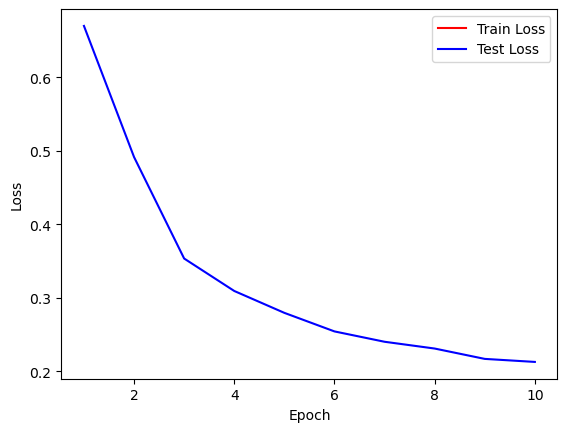

In [5]:
# Plot train & test los
train_steps = [x['epoch'] for x in logs['train']]
train_loss = [x['loss'] for x in logs['train']]

eval_steps = [x['epoch'] for x in logs['eval']]
eval_loss = [x['eval_loss'] for x in logs['eval']]
eval_f1 = [x['eval_f1'] for x in logs['eval']]


plt.plot(train_steps, train_loss, 'r', label='Train Loss')
plt.plot(eval_steps, eval_loss, 'b', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt

<module 'matplotlib.pyplot' from '/homes/gws/lleibm/miniconda3/envs/hf2/lib/python3.11/site-packages/matplotlib/pyplot.py'>

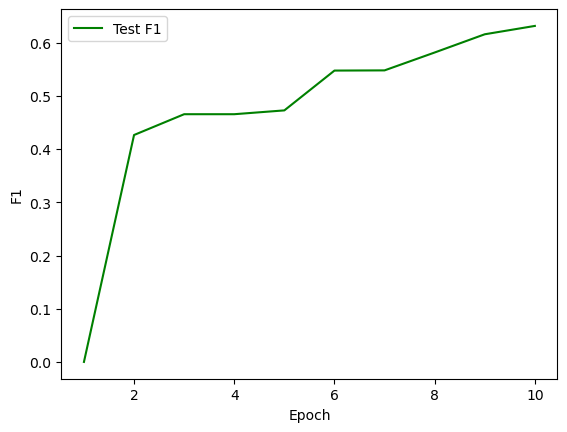

In [6]:
plt.plot(eval_steps, eval_f1, 'g', label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()
plt

# F1 Score Breakdown

Copy the "Reddit Rules!" Table 1, if possible, which breaks down F1 score per category
https://ojs.aaai.org/index.php/ICWSM/article/view/15033/14883

In [13]:
f1_eval_data = pd.read_csv(VAL_DATA_PATH)

label_cols = list(model.config.label2id.keys())

f1_predicted_data = pd.DataFrame(label_dataset(f1_eval_data.drop(columns=label_cols)))
f1_predicted_data.drop(columns=['Unnamed: 0'], inplace=True)
f1_predicted_data.to_csv(VAL_DATA_PATH, index=False)
f1_predicted_data

,subreddit,rule,rule_description,Prescriptive,Restrictive,Images,Commercialization,Illegal Content,Divisive Content,Respect for Others,...,Ban Mentioned,Karma/Score Mentioned,Post Content,Post Format,User-Related,Not a Rule,"Spam, Low Quality, Off-Topic, and Reposts",Post Tagging & Flairing,Peer Engagement,Links & External Content
0,SouthParkPhone,"2. Harassment \n Be civil, polite and respectf...",NaN,False,True,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
1,PeopleBeingJerks,5. Must be people being jerks.,NaN,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,HistoryPorn,"8. Tag colorized images, link original in a co...",NaN,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,bettafish,7. No irrelevant stuff.,NaN,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,DnDBehindTheScreen,5. The Whitelist Some people have made such ex...,NaN,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,PUBG,6. No spam/NSFW,NaN,False,True,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
96,OrlandoMagic,8. Low effort posts & upvote parties,NaN,False,True,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
97,buildapcsales,"7. Racist, sexist, political, or homophobic co...",NaN,False,True,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
98,EatingDisorders,4. No Commercial Posts We don't accept adverti...,NaN,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [12]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from IPython.display import display_markdown

# label_cols = [l for l in label_cols if l in f1_predicted_data.columns]
label_cols = sorted(list(model.config.label2id.keys()), key=lambda x: model.config.label2id[x])
f1_eval_data[label_cols] = f1_eval_data[label_cols].map(lambda x: x == 1)
f1_predicted_data[label_cols] = f1_predicted_data[label_cols].map(lambda x: x == 1)

f1_scores = {'Label': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': []}
for label in label_cols:
    y_true = f1_eval_data[label]
    y_pred = f1_predicted_data[label]
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    accuracy = accuracy_score(y_true, y_pred)
    
    f1_scores['Label'].append(label)
    f1_scores['Precision'].append(precision)
    f1_scores['Recall'].append(recall)
    f1_scores['F1'].append(f1)
    f1_scores['Accuracy'].append(accuracy)

f1_scores = pd.DataFrame(f1_scores)

# Display as markdown table
table = "| Label | Accuracy | Precision | Recall | F1 |\n"
table += "| --- | --- | --- | --- | --- |\n"
for row in f1_scores.iterrows():
    table += f"| {row[1]['Label']} | {row[1]['Accuracy']:.2} | {row[1]['Precision']:.2} | {row[1]['Recall']:.2} | {row[1]['F1']:.2} |\n"
display_markdown(table, raw=True)

/homes/gws/lleibm/miniconda3/envs/hf2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/homes/gws/lleibm/miniconda3/envs/hf2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/homes/gws/lleibm/miniconda3/envs/hf2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(re

| Label | Accuracy | Precision | Recall | F1 |
| --- | --- | --- | --- | --- |
| Prescriptive | 1.0 | 1.0 | 1.0 | 1.0 |
| Restrictive | 1.0 | 1.0 | 1.0 | 1.0 |
| Post Content | 1.0 | 1.0 | 1.0 | 1.0 |
| Post Format | 1.0 | 1.0 | 1.0 | 1.0 |
| User-Related | 1.0 | 0.0 | 0.0 | 0.0 |
| Not a Rule | 1.0 | 0.0 | 0.0 | 0.0 |
| Spam, Low Quality, Off-Topic, and Reposts | 1.0 | 1.0 | 1.0 | 1.0 |
| Post Tagging & Flairing | 1.0 | 0.0 | 0.0 | 0.0 |
| Peer Engagement | 1.0 | 0.0 | 0.0 | 0.0 |
| Links & External Content | 1.0 | 0.0 | 0.0 | 0.0 |
| Images | 1.0 | 0.0 | 0.0 | 0.0 |
| Commercialization | 1.0 | 0.0 | 0.0 | 0.0 |
| Illegal Content | 1.0 | 0.0 | 0.0 | 0.0 |
| Divisive Content | 1.0 | 0.0 | 0.0 | 0.0 |
| Respect for Others | 1.0 | 1.0 | 1.0 | 1.0 |
| Brigading | 1.0 | 0.0 | 0.0 | 0.0 |
| Ban Mentioned | 1.0 | 0.0 | 0.0 | 0.0 |
| Karma/Score Mentioned | 1.0 | 0.0 | 0.0 | 0.0 |
